## Summarising data across repeated runs of same workload 

In [1]:
import json
import pickle
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# GLOBAL VARIABLES / PARAMETERS
WORKLOAD = "WITHOUT_ISTIO_WITH_WORKLOAD"
TRACE_LOGS = f"{WORKLOAD}/"
PARSED_OUTPUTS = f"parsedOutputs/{WORKLOAD}"
NUM_RUNS = 3
FUNC_BLACKLIST = {"BLANK", "do_syscall_64()"}

#### Identifying most important functions by count

In [3]:
def get_runs():
    runs = []
    for run_data in os.listdir(PARSED_OUTPUTS):
        with open(os.path.join(PARSED_OUTPUTS, run_data), "r") as fd:
            data = json.load(fd)
            runs.append(data)
    return runs


Sample JSON
```json
"2016654": [
    {
      "function_name": "do_syscall_64() ",
      "time": 100134.8,
      "children": [
        {
          "function_name": "__x64_sys_epoll_wait() ",
          "time": 100129.9,
          "children": [
            {
              "function_name": "do_epoll_wait() ",
              "time": 100129.6,
              "children": [
                {
                  "function_name": "__fdget() ",
                  "time": 0.862,
                  "children": [
                    {
                      "function_name": "__fget_light();",
                      "time": 0.561,
                      "children": []
                    }
                  ]
                }
```

In [4]:
def get_function_counts(run, recurse=False):
    count = {}

    def get_counts(function, count, recurse):
        func_name = function["function_name"].strip().strip(";")
        if func_name not in FUNC_BLACKLIST:
            count[func_name] = count.get(func_name, 0) + 1
        if recurse:
            for child in function["children"]:
                get_counts(child, count, recurse)
    for pid in run:
        for function in run[pid]:
            get_counts(function, count, recurse)
        
    return count

def plot_counts(count, title=WORKLOAD, maxnum=20):
    maxnum = min(maxnum, len(count))
    x = sorted(list(count.keys()), key=lambda x: count[x], reverse=True)[ :maxnum]
    y = [count[_] for _ in x]


    plt.figure(figsize=(10, 4))
    plt.xticks(np.arange(len(x)), x, rotation=90)
    plt.title(title)
    plt.bar(x, y)
    plt.show()
    del x, y

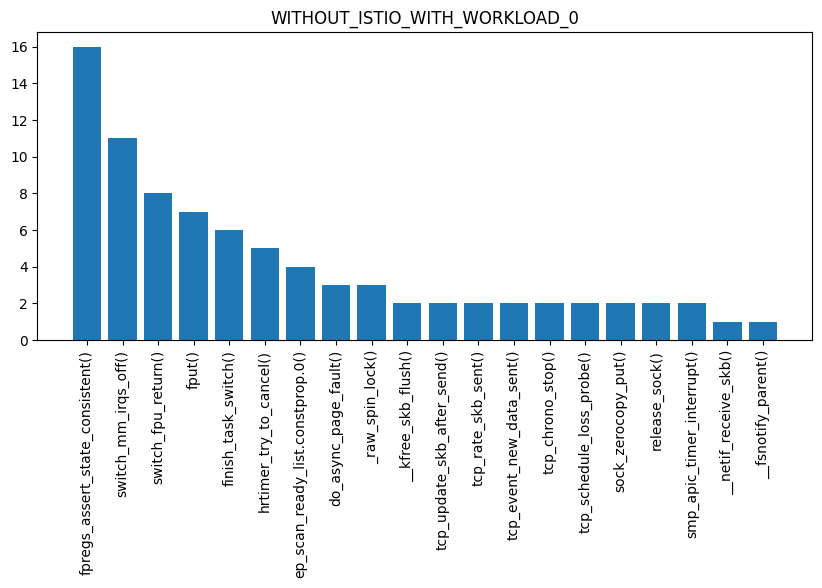

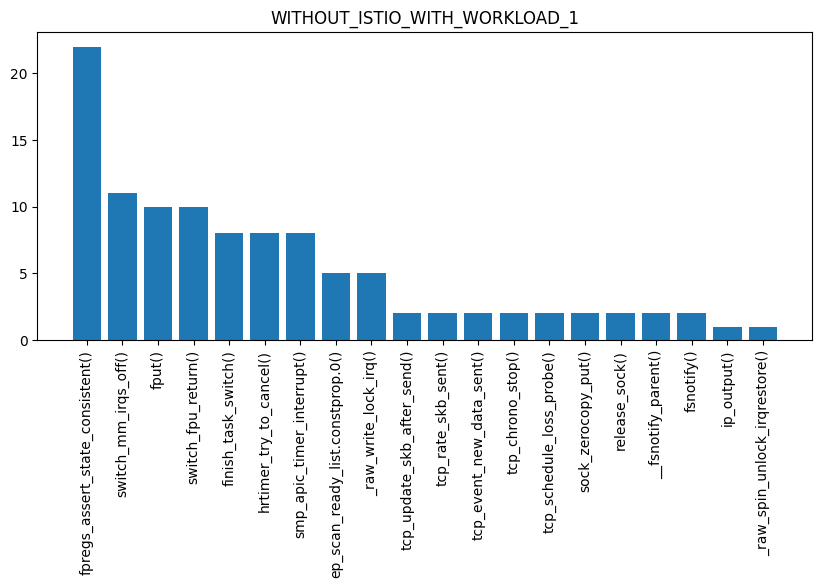

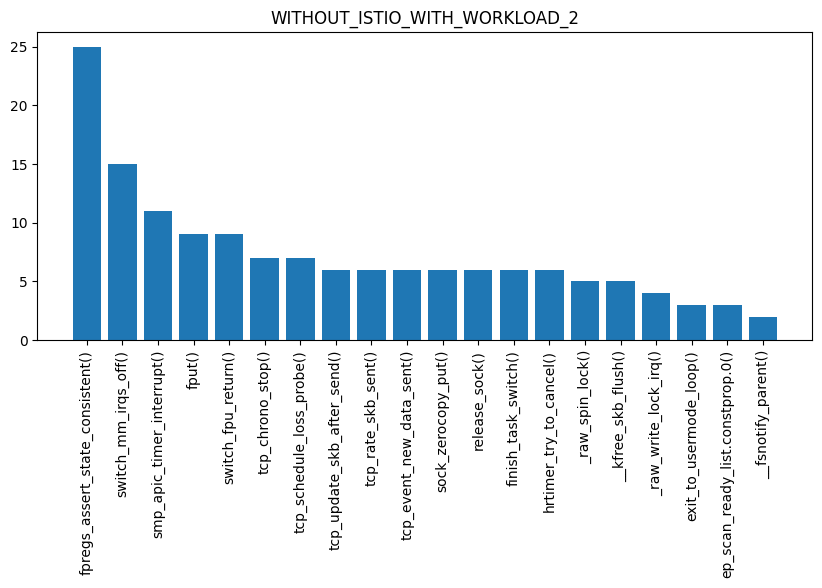

In [5]:
runs = get_runs()
for i in range(NUM_RUNS):
    count = get_function_counts(runs[i])
    plot_counts(count, title=f"{WORKLOAD}_{i}")

Points of Note
* switch_mm_irqs_off() is the most called function call consistenctly
* The function call counts are identical across the runs
* There are a total of only around 10-13 functions called in the idle runs at the top level of the callgraph

#### Parsing the callgraph recursively

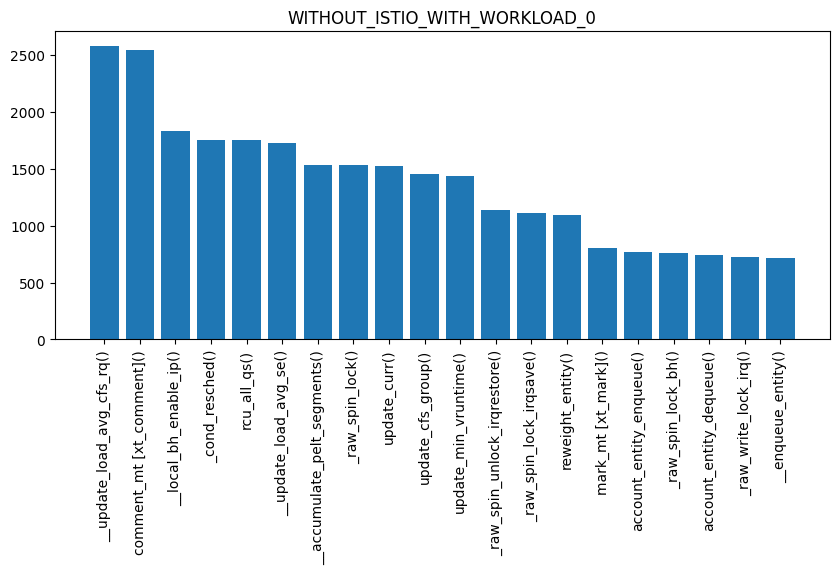

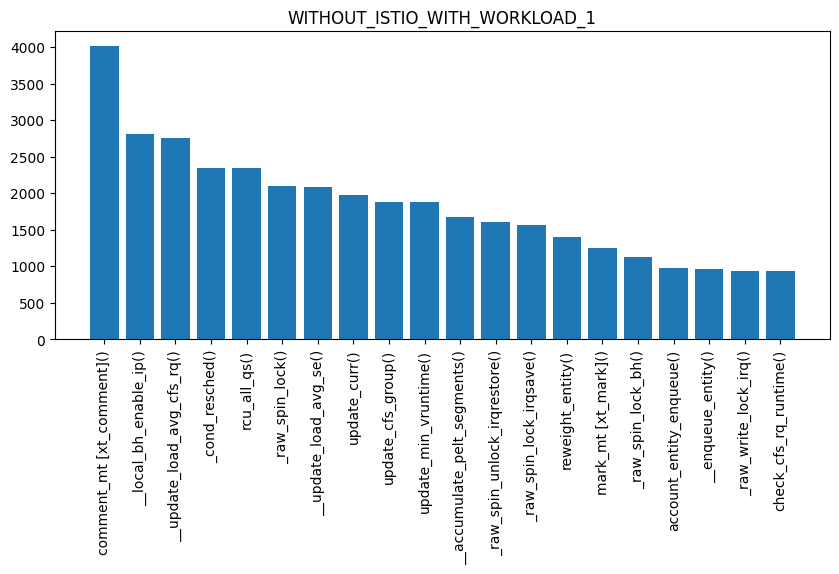

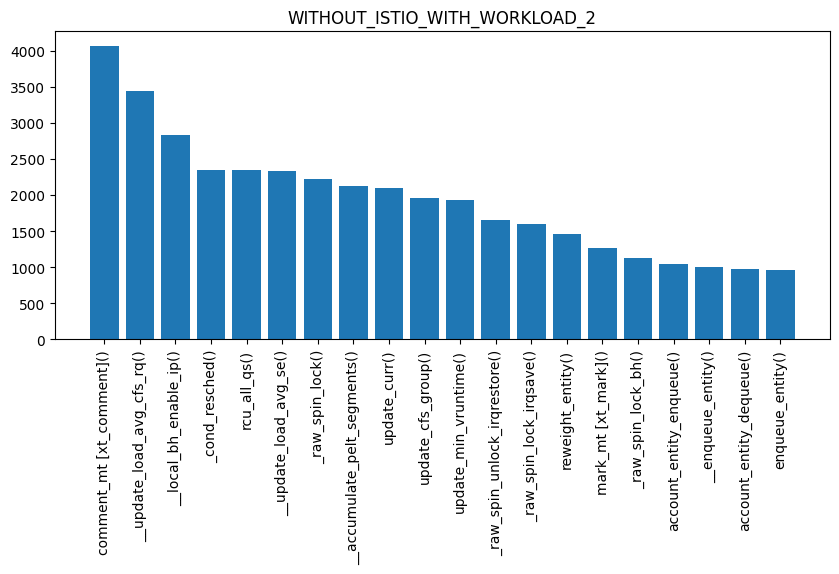

In [6]:
for i in range(NUM_RUNS):
    count = get_function_counts(runs[i], recurse=True)
    plot_counts(count, title=f"{WORKLOAD}_{i}")

In [7]:
function_counts = [get_function_counts(run, recurse=True) for run in runs]

with open(f"pickles/function_counts/{WORKLOAD}.pickle", "wb") as f:
    pickle.dump(function_counts, file=f)

In [8]:
print(len(function_counts[0]), len(function_counts[1]), len(function_counts[2]))

821 766 961


In [9]:
for i in range(NUM_RUNS):
    for j in range(NUM_RUNS):
        if i == j:
            continue

        print(f"Calls in {i} but not in {j} ", 
            set(function_counts[i].keys()).difference(set(function_counts[j].keys())), sep="\n", end="\n")
        print()

Calls in 0 but not in 1 
{'page_add_new_anon_rmap()', 'mem_cgroup_commit_charge()', 'do_anonymous_page()', 'sched_offline_group()', '__put_cred()', 'down_read_trylock()', '__count_memcg_events()', 'futex_wait_setup()', 'can_migrate_task()', 'page_counter_try_charge()', 'vmacache_find()', '__next_zones_zonelist()', 'alloc_pages_vma()', 'propagate_protected_usage()', 'unfreeze_partials.isra.0()', 'mem_cgroup_try_charge_delay()', 'mem_cgroup_throttle_swaprate()', '__sk_mem_reclaim()', 'page_counter_cancel()', '__mod_node_page_state()', 'tcp_write_timer_handler()', 'get_mem_cgroup_from_mm()', 'file_free_rcu()', 'get_task_policy.part.0()', '__sk_mem_reduce_allocated()', 'handle_mm_fault()', 'process_timeout()', 'sched_autogroup_exit()', 'tcp_write_timer()', 'eventfd_write()', 'kernel_poison_pages()', '__x64_sys_nanosleep()', 'page_poisoning_enabled()', 'get_page_from_freelist()', '__inc_numa_state()', 'should_fail_alloc_page()', 'mem_cgroup_charge_statistics()', 'kthread_is_per_cpu()', '__g

In [10]:
def get_count_diff(function_counts):
    count_diff = {}
    for i in range(NUM_RUNS):
        for j in range(NUM_RUNS):
            if i==j:
                continue
            count_diff[f"{i}-{j}"]= {}
            for function in function_counts[i].keys():
                lhs = function_counts[i].get(function, 0) 
                rhs = function_counts[j].get(function, 0)
                if lhs <= rhs: 
                    continue
                count_diff[f"{i}-{j}"][function] = (lhs - rhs) / lhs * 100
    return count_diff


In [11]:
diff_count = get_count_diff(function_counts=function_counts)

In [12]:
[(x, diff_count["0-1"][x]) for x in sorted(diff_count["0-1"], key=lambda x: diff_count["0-1"][x], reverse=True)]

[('process_timeout()', 100.0),
 ('can_migrate_task()', 100.0),
 ('kthread_is_per_cpu()', 100.0),
 ('do_async_page_fault()', 100.0),
 ('do_page_fault()', 100.0),
 ('__do_page_fault()', 100.0),
 ('down_read_trylock()', 100.0),
 ('find_vma()', 100.0),
 ('vmacache_find()', 100.0),
 ('handle_mm_fault()', 100.0),
 ('mem_cgroup_from_task()', 100.0),
 ('__count_memcg_events()', 100.0),
 ('__handle_mm_fault()', 100.0),
 ('pmd_devmap_trans_unstable()', 100.0),
 ('do_anonymous_page()', 100.0),
 ('alloc_pages_vma()', 100.0),
 ('__get_vma_policy()', 100.0),
 ('get_vma_policy.part.0()', 100.0),
 ('get_task_policy.part.0()', 100.0),
 ('policy_nodemask()', 100.0),
 ('policy_node()', 100.0),
 ('__alloc_pages_nodemask()', 100.0),
 ('should_fail_alloc_page()', 100.0),
 ('__next_zones_zonelist()', 100.0),
 ('get_page_from_freelist()', 100.0),
 ('__inc_numa_state()', 100.0),
 ('prep_new_page()', 100.0),
 ('kernel_poison_pages()', 100.0),
 ('page_poisoning_enabled()', 100.0),
 ('mem_cgroup_try_charge_delay(

In [13]:
[(x, diff_count["0-2"][x]) for x in sorted(diff_count["0-2"], key=lambda x: diff_count["0-2"][x], reverse=True)]

[('process_timeout()', 100.0),
 ('__switch_to_xtra()', 100.0),
 ('syscall_trace_enter()', 100.0),
 ('__secure_computing()', 100.0),
 ('__seccomp_filter()', 100.0),
 ('futex_wait()', 100.0),
 ('futex_wait_setup()', 100.0),
 ('get_futex_value_locked()', 100.0),
 ('futex_wait_queue_me()', 100.0),
 ('__x64_sys_epoll_pwait()', 100.0),
 ('set_user_sigmask()', 100.0),
 ('__x64_sys_nanosleep()', 100.0),
 ('get_timespec64()', 100.0),
 ('hrtimer_nanosleep()', 100.0),
 ('do_nanosleep()', 100.0),
 ('tcp_write_timer()', 100.0),
 ('tcp_write_timer_handler()', 100.0),
 ('__put_cred()', 100.0),
 ('sched_autogroup_exit()', 100.0),
 ('sched_offline_group()', 100.0),
 ('unregister_fair_sched_group()', 100.0),
 ('sched_destroy_group()', 100.0),
 ('unfreeze_partials.isra.0()', 100.0),
 ('unix_poll()', 100.0),
 ('start_cfs_bandwidth.part.0()', 100.0),
 ('drop_futex_key_refs.isra.0()', 78.57142857142857),
 ('__x64_sys_futex()', 76.92307692307693),
 ('do_futex()', 76.92307692307693),
 ('get_futex_key()', 76.9

In [14]:
[(x, diff_count["1-0"][x]) for x in sorted(diff_count["1-0"], key=lambda x: diff_count["1-0"][x], reverse=True)]

[('rcu_gp_kthread_wake()', 100.0),
 ('swake_up_one()', 100.0),
 ('swake_up_locked.part.0()', 100.0),
 ('pipe_poll()', 100.0),
 ('pipe_read()', 100.0),
 ('generic_pipe_buf_confirm()', 100.0),
 ('anon_pipe_buf_release()', 100.0),
 ('touch_atime()', 100.0),
 ('atime_needs_update()', 100.0),
 ('__mnt_drop_write()', 100.0),
 ('tcp_validate_incoming()', 100.0),
 ('tcp_urg()', 100.0),
 ('tcp_data_queue()', 100.0),
 ('tcp_try_coalesce()', 100.0),
 ('skb_try_coalesce()', 100.0),
 ('kfree_skb_partial()', 100.0),
 ('kick_ilb()', 100.0),
 ('housekeeping_cpumask()', 100.0),
 ('tcp_send_ack()', 100.0),
 ('__tcp_send_ack.part.0()', 100.0),
 ('__sock_wfree()', 100.0),
 ('inet_sk_rx_dst_set()', 100.0),
 ('rcu_report_qs_rnp()', 83.33333333333334),
 ('update_group_capacity()', 80.0),
 ('__x64_sys_recvfrom()', 73.84615384615385),
 ('__sys_recvfrom()', 73.84615384615385),
 ('__x64_sys_writev()', 73.33333333333333),
 ('do_writev()', 73.33333333333333),
 ('vfs_writev()', 73.33333333333333),
 ('rw_copy_check_

In [15]:
[(x, diff_count["2-0"][x]) for x in sorted(diff_count["2-0"], key=lambda x: diff_count["2-0"][x], reverse=True)]

[('kick_ilb()', 100.0),
 ('housekeeping_cpumask()', 100.0),
 ('detach_entity_cfs_rq()', 100.0),
 ('propagate_entity_cfs_rq()', 100.0),
 ('attach_task()', 100.0),
 ('smp_call_function_interrupt()', 100.0),
 ('generic_smp_call_function_single_interrupt()', 100.0),
 ('flush_smp_call_function_queue()', 100.0),
 ('do_kernel_range_flush()', 100.0),
 ('native_flush_tlb_one_user()', 100.0),
 ('neigh_timer_handler()', 100.0),
 ('_raw_write_lock()', 100.0),
 ('tcp_keepalive_timer()', 100.0),
 ('inet_csk_reset_keepalive_timer()', 100.0),
 ('tw_timer_handler()', 100.0),
 ('inet_twsk_kill()', 100.0),
 ('inet_twsk_bind_unhash()', 100.0),
 ('inet_bind_bucket_destroy()', 100.0),
 ('inet_twsk_put()', 100.0),
 ('inet_twsk_free()', 100.0),
 ('tcp_twsk_destructor()', 100.0),
 ('hrtimer_force_reprogram()', 100.0),
 ('estimation_timer [ip_vs]()', 100.0),
 ('tcp_urg()', 100.0),
 ('tcp_data_queue()', 100.0),
 ('tcp_send_ack()', 100.0),
 ('__tcp_send_ack.part.0()', 100.0),
 ('__sock_wfree()', 100.0),
 ('inet_s

In [16]:
[(x, diff_count["2-1"][x]) for x in sorted(diff_count["2-1"], key=lambda x: diff_count["2-1"][x], reverse=True)]

[('can_migrate_task()', 100.0),
 ('kthread_is_per_cpu()', 100.0),
 ('detach_entity_cfs_rq()', 100.0),
 ('propagate_entity_cfs_rq()', 100.0),
 ('attach_task()', 100.0),
 ('smp_call_function_interrupt()', 100.0),
 ('generic_smp_call_function_single_interrupt()', 100.0),
 ('flush_smp_call_function_queue()', 100.0),
 ('do_kernel_range_flush()', 100.0),
 ('native_flush_tlb_one_user()', 100.0),
 ('neigh_timer_handler()', 100.0),
 ('_raw_write_lock()', 100.0),
 ('tcp_keepalive_timer()', 100.0),
 ('inet_csk_reset_keepalive_timer()', 100.0),
 ('__sk_mem_reclaim()', 100.0),
 ('__sk_mem_reduce_allocated()', 100.0),
 ('tw_timer_handler()', 100.0),
 ('inet_twsk_kill()', 100.0),
 ('inet_twsk_bind_unhash()', 100.0),
 ('inet_bind_bucket_destroy()', 100.0),
 ('inet_twsk_put()', 100.0),
 ('inet_twsk_free()', 100.0),
 ('tcp_twsk_destructor()', 100.0),
 ('hrtimer_force_reprogram()', 100.0),
 ('estimation_timer [ip_vs]()', 100.0),
 ('epi_rcu_free()', 100.0),
 ('skb_put()', 100.0),
 ('skb_copy_bits()', 100.

In [17]:
[(x, diff_count["1-2"][x]) for x in sorted(diff_count["1-2"], key=lambda x: diff_count["1-2"][x], reverse=True)]

[('__switch_to_xtra()', 100.0),
 ('syscall_trace_enter()', 100.0),
 ('__secure_computing()', 100.0),
 ('__seccomp_filter()', 100.0),
 ('__x64_sys_epoll_pwait()', 100.0),
 ('set_user_sigmask()', 100.0),
 ('pipe_poll()', 100.0),
 ('pipe_read()', 100.0),
 ('generic_pipe_buf_confirm()', 100.0),
 ('anon_pipe_buf_release()', 100.0),
 ('touch_atime()', 100.0),
 ('atime_needs_update()', 100.0),
 ('__mnt_drop_write()', 100.0),
 ('rcu_gp_kthread_wake()', 66.66666666666666),
 ('swake_up_one()', 66.66666666666666),
 ('swake_up_locked.part.0()', 66.66666666666666),
 ('tick_do_update_jiffies64.part.0()', 66.66666666666666),
 ('do_timer()', 66.66666666666666),
 ('calc_global_load()', 66.66666666666666),
 ('update_wall_time()', 66.66666666666666),
 ('timekeeping_advance()', 66.66666666666666),
 ('ntp_tick_length()', 66.66666666666666),
 ('timekeeping_update()', 66.66666666666666),
 ('ntp_get_next_leap()', 66.66666666666666),
 ('update_vsyscall()', 66.66666666666666),
 ('raw_notifier_call_chain()', 66.

### Conclusion
* There is not a signifiicant difference between the counts of the various calls.
* Especially in without-istio-without-workload, most calls are seen very infrequently 
* The most frequent calls can be noted and assigned low weightage in future anlaysis